# MNIST - drifting DiT demo (fast)

This notebook trains a small **DiT-like generator** on MNIST (28×28×1) using the drifting objective from:
https://arxiv.org/abs/2602.04770

What you’ll see:
- a few real digits
- training loss curve
- periodic grids of generated digits (conditioned on class label, 10×10 grid)


In [ ]:
import os, sys


# NOTE: must run BEFORE importing jax.
for k in ("JAX_PLATFORMS", "JAX_PLATFORM_NAME"):
    os.environ.pop(k, None)

if sys.platform == "darwin":
    os.environ["JAX_PLATFORMS"] = "cpu"


In [ ]:
import os, time
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import optax

from driftax.datasets import load_mnist_npz, preprocess_mnist
from driftax.models import DiTLatent2D, DiTLatent2DConfig
from driftax.models import ClassEmbed
from driftax.models import TinyConvEncoder
from driftax.drift import drifting_loss_features

print("JAX devices:", jax.devices())


JAX devices: [CpuDevice(id=0)]


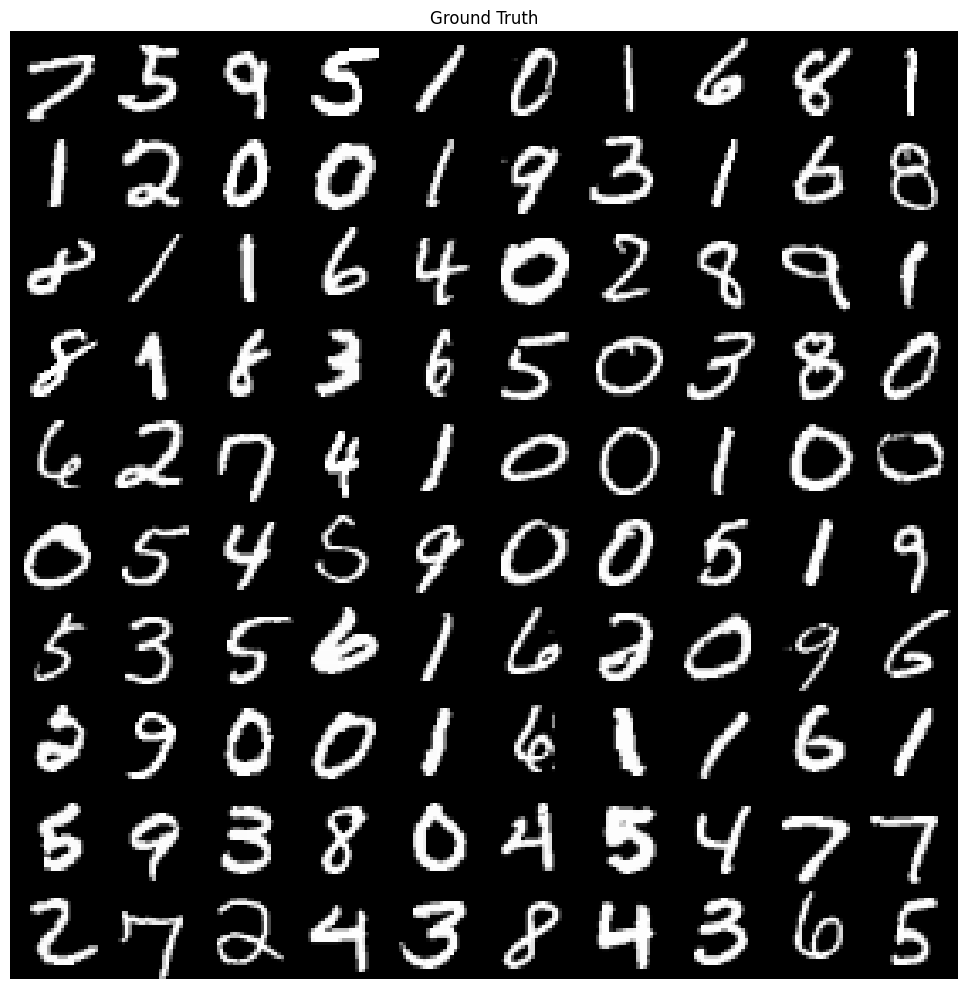

In [8]:
# Load MNIST
x_train_u8, y_train_u8, x_test_u8, y_test_u8 = load_mnist_npz("data")
x_train = preprocess_mnist(x_train_u8)  # float32 [-1,1], [N,28,28,1]
y_train = y_train_u8.astype(np.int32)

# plot training
idx = np.random.default_rng(0).choice(len(x_train), size=100, replace=False)
imgs = x_train[idx]

def show_grid(imgs, nrow=10, title=""):
    imgs01 = (np.clip(imgs, -1, 1) + 1.0) * 0.5
    N, H, W, C = imgs01.shape
    ncol = int(np.ceil(N / nrow))
    grid = np.ones((ncol * H, nrow * W), dtype=np.float32)
    for i in range(N):
        r = i // nrow
        c = i % nrow
        grid[r*H:(r+1)*H, c*W:(c+1)*W] = imgs01[i,:,:,0]
    plt.figure(figsize=(nrow, ncol))
    plt.imshow(grid, cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
    plt.title(title)
    plt.tight_layout()
    plt.show()

show_grid(imgs, title="Ground Truth")


In [ ]:
cfg = DiTLatent2DConfig(
    h=28, w=28, ch=1,
    patch=2,
    dim=256,
    depth=6,
    heads=8,
    cond_dim=256,
    num_context_tokens=0,
    drop=0.0,
)

gen = DiTLatent2D(cfg)
class_emb = ClassEmbed(num_classes=10, out_dim=cfg.cond_dim)

# Feature encoder
phi = TinyConvEncoder(base=32)

# Put training data on device
x_train_d = jnp.asarray(x_train)
y_train_d = jnp.asarray(y_train)
N = x_train_d.shape[0]

# Build per class index table for fast conditional positives
def make_class_index(labels_np, num_classes=10):
    idxs = [np.where(labels_np == c)[0] for c in range(num_classes)]
    counts = np.array([len(v) for v in idxs], dtype=np.int32)
    M = int(max(counts))
    table = np.zeros((num_classes, M), dtype=np.int32)
    for c in range(num_classes):
        v = idxs[c]
        table[c, :len(v)] = v
        table[c, len(v):] = v[0] if len(v) else 0
    return table, counts

class_table, class_counts = make_class_index(y_train, 10)
class_table_d = jnp.asarray(class_table)
class_counts_d = jnp.asarray(class_counts).astype(jnp.float32)

def sample_pos_images(key, cls):
    # cls: [B]
    u = jax.random.uniform(key, cls.shape, dtype=jnp.float32)
    cnt = jnp.take(class_counts_d, cls)  # [B]
    r = jnp.minimum((u * cnt).astype(jnp.int32), (cnt.astype(jnp.int32) - 1))
    idx = class_table_d[cls, r]
    return x_train_d[idx]

# init params
key = jax.random.PRNGKey(0)
key, k0, k1, k2 = jax.random.split(key, 4)
dummy_z = jnp.zeros((1, cfg.h, cfg.w, cfg.ch), dtype=jnp.float32)
dummy_cls = jnp.zeros((1,), dtype=jnp.int32)

params = {}
params["class_emb"] = class_emb.init(k0, dummy_cls)
cond0 = class_emb.apply(params["class_emb"], dummy_cls)
params["gen"] = gen.init(k1, dummy_z, cond0, train=True)
params["phi"] = phi.init(k2, jnp.zeros((1, 28, 28, 1), dtype=jnp.float32), train=False)

lr = 2e-4
opt = optax.adamw(lr)
opt_state = opt.init(params)

temps = (0.02, 0.05, 0.2)
batch = 128
steps = 2000
plot_every = 1000
print_every = 50

def loss_fn(params, key):
    key, kz, kc, kp = jax.random.split(key, 4)
    cls = jax.random.randint(kc, (batch,), 0, 10)
    cond = class_emb.apply(params["class_emb"], cls)
    z = jax.random.normal(kz, (batch, cfg.h, cfg.w, cfg.ch), dtype=jnp.float32)
    x_gen = gen.apply(params["gen"], z, cond, train=True)
    x_pos = sample_pos_images(kp, cls)

    fx_list = phi.apply(params["phi"], x_gen, train=False)
    fp_list = phi.apply(params["phi"], x_pos, train=False)

    loss = 0.0
    for fx, fp in zip(fx_list, fp_list):
        fxv = jnp.mean(fx, axis=(1, 2))  # [B,C]
        fpv = jnp.mean(fp, axis=(1, 2))
        loss = loss + drifting_loss_features(
            x_feat=fxv,
            pos_feat=fpv,
            temps=temps,
            neg_feat=fxv,
            feature_normalize=True,
            drift_normalize=False,
        )
    return loss / float(len(fx_list))

@jax.jit
def step_fn(params, opt_state, key):
    loss, grads = jax.value_and_grad(lambda p: loss_fn(p, key))(params)
    updates, opt_state2 = opt.update(grads, opt_state, params)
    params2 = optax.apply_updates(params, updates)
    return params2, opt_state2, key, loss

def sample_grid(params, key):
    # 100 samples: 10 per class
    cls = jnp.repeat(jnp.arange(10, dtype=jnp.int32), 10)
    cond = class_emb.apply(params["class_emb"], cls)
    z = jax.random.normal(key, (cls.shape[0], cfg.h, cfg.w, cfg.ch), dtype=jnp.float32)
    x = gen.apply(params["gen"], z, cond, train=False)
    return np.array(x)

loss_hist = []
for s in range(1, steps + 1):
    params, opt_state, key, loss = step_fn(params, opt_state, key)
    lv = float(loss)
    loss_hist.append(lv)

    if s % print_every == 0 or s == 1:
        print(f"step {s:4d}  loss {lv:.3e}")

    if s == 1 or (plot_every and s % plot_every == 0) or s == steps:
        key, kvis = jax.random.split(key)
        imgs = sample_grid(params, kvis)
        show_grid(imgs, title=f"Generated digits (step {s})")

# plotting out the loss
loss_hist = np.asarray(loss_hist, dtype=np.float32)
plt.figure(figsize=(6, 3))
plt.plot(loss_hist, alpha=0.8)
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.xlabel("Step"); plt.ylabel("Loss")
plt.title("driftax MNIST drifting loss")
plt.tight_layout()
plt.show()